fundamental frequency :  125.43166685511459 Hz
frequency 1 is 125.43166685511459 Hz
fundamental frequency :  125.43166685511459 Hz
frequency 2 is 250.86333371022917 Hz
fundamental frequency :  125.43166685511459 Hz
frequency 3 is 376.29500056534374 Hz
fundamental frequency :  125.43166685511459 Hz
frequency 4 is 501.72666742045834 Hz
fundamental frequency :  125.43166685511459 Hz
frequency 5 is 627.158334275573 Hz
fundamental frequency :  125.43166685511459 Hz
frequency 6 is 752.5900011306875 Hz
fundamental frequency :  125.43166685511459 Hz
frequency 7 is 878.0216679858021 Hz
fundamental frequency :  125.43166685511459 Hz
frequency 8 is 1003.4533348409167 Hz
fundamental frequency :  125.43166685511459 Hz
frequency 9 is 1128.8850016960312 Hz


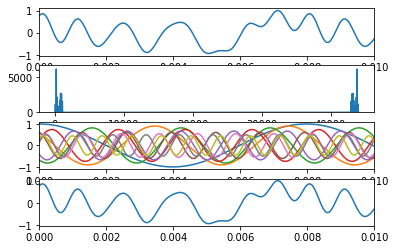

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import struct
from scipy.io.wavfile import write, read

# Default values are m = 0.15 * 10**(-3) kg, l = 1.4 * 10**(-3) m, T = 3 N
m = 4.6 * 10**(-3) #kg 
l = 1.4 * 10**(-3) #m
T =  1 #N

def frequency_from_fundamental(n, round_at=0, logs=False):
    
    """Calculate frequency based on a {mass + ruberband} system."""

    frequency = 1/np.pi * np.sqrt(n**2*T/(m*l))
    
    if round_at:
        frequency = round(frequency, round_at)
        
    if logs:
        print("fundamental frequency : ", 1/np.pi * np.sqrt(T/(m*l)), "Hz")
        print("frequency", n,  "is", frequency, "Hz")
        
    return frequency

def add_sine_waves(listOfSineWave, logs=False):
    
    sumOfSineWaves = np.copy(listOfSineWave[0])

    if logs: 
        print("sumOfSineWaves", sumOfSineWaves)
        print(listOfSineWave.ndim)

    for i in range(1, len(listOfSineWave)):
       sumOfSineWaves += listOfSineWave[i]
       #print("sum at", i, ",", sumOfSineWaves)

    if logs:
        print("sumOfSineWaves :", sumOfSineWaves)

    return sumOfSineWaves

def createWaveFile(name, listOfSineWave, samplingRate = 44100, logs=False):

    F = wave.open(str(name) + '.wav', 'wb')
    F.setnchannels(1)
    F.setsampwidth(2)
    F.setframerate(samplingRate)

    if logs:
        print("dimension of listOfSines array :", listOfSineWave.ndim)

    if listOfSineWave.ndim == 1:
        for w in listOfSineWave:
            F.writeframes(struct.pack('f', w))
    else:
        for sine in listOfSineWave:
            print(sine.shape)
            for w in sine:
                #print(type(int(w)))    
                F.writeframes(struct.pack('f', w))
    F.close()
    print(str(name) + ".wav successfully created!")

    return str(name) + ".wav"

def visualize_wav(f):

    """Decompose wav file into int16 array. Return a time linspace to plot and the array"""

    framerate, frames = read(f)

    return framerate, frames

def main():
    samplingRate = 44100
    samplingInterval = 1/samplingRate

    nLowHarmonics = 9
    nHighHarmonics = 0
    amplitudelow = 0.1
    amplitudehigh = 70000

    t = np.arange(0, 1, samplingInterval)
    lowFrequencySineWaves = np.zeros((nLowHarmonics, t.size))
    highFrequencySineWaves = np.zeros((nHighHarmonics, t.size))

    frequencies = []

    #Creating the lower harmonics from the lower fundamental
    for i in range(nLowHarmonics):
        #create sine wave from lower frequencies
        frequencies.append(frequency_from_fundamental(i+1, round_at=0))
        lowFrequencySineWaves[i] = np.exp(-amplitudelow *i) * np.cos(2*np.pi * frequency_from_fundamental(i+1, round_at=0, logs=True) * (t+2*i*np.pi/9))
        #plt.plot(t, sine_waves[i])
    #print("lowFrequencySineWaves", lowFrequencySineWaves)
    
    #Creating the higher harmonics from the higher fundamental
    for i in range(nHighHarmonics):
        #create sine wave from lower frequencies
        highFrequencySineWaves[i] = amplitudehigh * np.sin(2*np.pi*frequency_from_fundamental(i+1, round_at=0) * t)
        #plt.plot(t, sine_waves[i])
    #print("highFrequencySineWaves", highFrequencySineWaves)

    #Arbitrarly modifying our data so it sounds a little bit less terrible (and so it fits the data)
    #np.delete(lowFrequencySineWaves, 1)
    #np.delete(lowFrequencySineWaves, 2)
    #np.delete(lowFrequencySineWaves, 3)

    #Group every sine waves into one 2D-array
    sineWaves = np.concatenate((lowFrequencySineWaves, highFrequencySineWaves))
    #print("waves:", sine_waves)

    #Add sine wave together using add method
    createdSineWave = add_sine_waves(sineWaves)
    createdSineWave *= 1/max(createdSineWave)
    wavFile = write("test.wav", samplingRate, createdSineWave.astype('float32'))
    #print("createdSineWave", createdSineWave)

    #Calculate the spectrum of createdSineWave using fft
    spectrum_fft = np.fft.fft(createdSineWave)

    #Compute the ouput from sine wave original array
    waveFromIfft = np.fft.ifft2(sineWaves)
    #print(waveFromIfft)

    xmax = 0.01
    
    fig, axs = plt.subplots(4)
    axs[0].plot(t, createdSineWave)
    axs[0].set_xlim([0, xmax])

    axs[1].plot(np.real(spectrum_fft))
    axs[1].set_ylim(0)

    for wave in sineWaves:
        axs[2].plot(t, wave)
    axs[2].set_xlim([0, xmax])
    
    #Visualize wav file 
    framerate, frames = visualize_wav("test.wav")
    t_wav = np.arange(0, len(frames))/framerate
    axs[3].plot(t_wav, frames)
    axs[3].set_xlim([0, xmax])
    plt.show()


if __name__ == "__main__":
    main()